In [55]:
# NOTE: GermanQuAD predictions seem to be okay generally
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'scripts', 'utils')))
import utils

predictions_path = "model_results/tuned/bert-large-cased-whole-word-masking-finetuned-squad_G_predictions.json"
dataset_path = "data/GermanQuAD/GermanQuAD_test.json"
is_valid = utils.validate_predictions(predictions_path, dataset_path)
if is_valid:
    print("Predictions file is valid.")
else:
    print("Predictions file is invalid.")

Total IDs in dataset: 2204
Total IDs in predictions: 2204
Missing IDs in predictions: 0
Missing IDs in dataset: 0
Predictions file is valid.


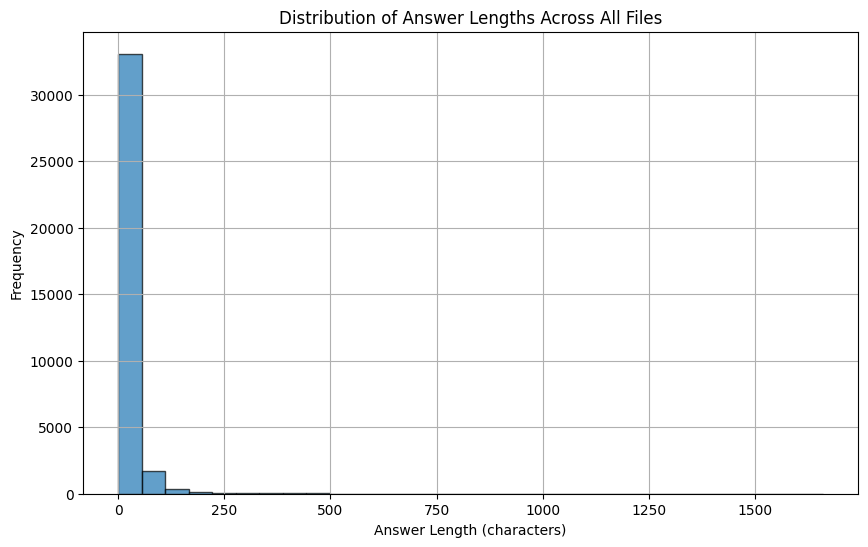

In [22]:
# NOTE: 
# I've been checking the distribution of answer lenghts for 
# fine-tuned models to make a feasible yet sufficiently high assumption
# on max_new_tokens (answer length) in base.py
# --> 250 seems sufficient here for the majority of questions
import utils

# Add directory to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'scripts', 'utils')))

utils.plot_answer_length_distribution('model_results/tuned')

In [73]:
# Cell 1
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Datasets
datasets = ["SQuAD", "G"]

# Manual dictionary for model names
manual_model_name_map = {
    # base SQuAD
    'Llama3-ChatQA-1.5-8B': 'llama3-8b\n(8B)', 
    'falcon-7b-instruct': 'falcon-7b\n(7B)',
    
    # tuned: SQuAD
    'bert': 'bert\n(?)',
    'bert-large-cased-whole-word-masking-finetuned-squad': 'largeBERT\n(336M)',
    'distilbert-base-cased-distilled-squad': 'distilBERT\n(65M)',
    'mdeberta-v3-base-squad2': 'mdeBERTa\n(278M)',
    'roberta-base-squad2': 'roBERTa_base\n(124M)',
    'roberta-large-squad2': 'roBERTa_large\n(354M)',
    'xlm-roberta-base-squad2': 'xlm_roBERTa_base\n(277M)', 
    
    # Gtuned: SQuAD
    'bert-multi-english-german-squad2': 'multilang_BERT\n(177M)', 
    'gelectra-base-germanquad-distilled': 'GElectra_distil\n(109M)', 
    'gelectra-base-germanquad': 'GElectra_base\n(109M)', 
    'gelectra-large-germanquad': 'GElectra_large\n(335M)', 
}

# Function to load timing results
def load_timing_results(timing_results_path):
    with open(timing_results_path, 'r') as f:
        timing_results = json.load(f)
    return timing_results

# Function to load json files and extract relevant information
def load_json_files(base_dir, subdirs, datasets):
    results = []
    model_name_map = {}
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        for file_name in os.listdir(subdir_path):
            if file_name.endswith('_eval_results.json'):
                with open(os.path.join(subdir_path, file_name), 'r') as f:
                    data = json.load(f)
                    
                    # Model Name
                    model_name = file_name.replace('_eval_results.json', '')
                    short_name = manual_model_name_map.get(model_name, model_name.split('-')[0])
                    model_name_map[short_name] = model_name
                    
                    for dataset in datasets:
                        # Evaluation script for SQuAD v2 / GermanQuAD
                        eval_v2 = data.get(dataset, {}).get('evaluate-v2', {})
                        exact = eval_v2.get('exact', 0) / 100  # Rescale to 0-1
                        f1 = eval_v2.get('f1', 0) / 100  # Rescale to 0-1
                        
                        # HasAns metrics
                        has_ans_exact = eval_v2.get('HasAns_exact', 0) / 100
                        has_ans_f1 = eval_v2.get('HasAns_f1', 0) / 100
                        
                        # NoAns metrics
                        no_ans_exact = eval_v2.get('NoAns_exact', 0)
                        no_ans_f1 = eval_v2.get('NoAns_f1', 0)
                        
                        # BLEU 
                        bleu_score = data.get(dataset, {}).get('bleu', {}).get('HasAns_bleu', 0)
                        
                        # ROUGE
                        rouge_scores = data.get(dataset, {}).get('rouge', {}).get('HasAns_rouge', {})
                        rouge1 = rouge_scores.get('rouge1', {}).get('f', 0)
                        rouge2 = rouge_scores.get('rouge2', {}).get('f', 0)
                        rougeL = rouge_scores.get('rougeL', {}).get('f', 0)
                        rouge_score = np.mean([rouge1, rouge2, rougeL])
                        
                        # BERT
                        bert_score = data.get(dataset, {}).get('bertscore', {}).get('HasAns_BERTScore', {}).get('F1', 0)
                        
                        # Cumulative scores 
                        eval_v2_score = 1/2 * (exact + f1)
                        eval_v2_score_hasAns =  1/2 * (has_ans_exact + has_ans_f1)
                        eval_other = 1/3 * (bert_score + bleu_score + rouge_score)
                        overall_score = 1/2 * (eval_v2_score_hasAns + eval_other)
                        
                        results.append({
                            'dataset': dataset,
                            'short_name': short_name,
                            'model': model_name,
                            'exact': exact,
                            'f1': f1,
                            'has_ans_exact': has_ans_exact,
                            'has_ans_f1': has_ans_f1,
                            'no_ans_exact': no_ans_exact,
                            'no_ans_f1': no_ans_f1,
                            'bleu_score': bleu_score,
                            'rouge_score': rouge_score,
                            'bert_score': bert_score,
                            'eval_v2_score': eval_v2_score,
                            'eval_v2_score_hasAns': eval_v2_score_hasAns, 
                            'eval_other': eval_other,
                            'overall_score': overall_score
                        })
    return results, model_name_map

In [102]:
# Function to plot bar chart with line graph for overall_score
def plot_bar_chart_with_line_graph(df, dataset_name, figure_root):
    df_sorted = df[df['dataset'] == dataset_name].sort_values(by='overall_score')
    plt.figure(figsize=(23, 6))
    bar_width = 0.25
    index = np.arange(len(df_sorted))

    # Bar chart for F1 Score, Exact Match, and Eval Other with subtle colors
    plt.bar(index, df_sorted['has_ans_f1'], bar_width, label='F1 Score', color='lightblue')
    plt.bar(index + bar_width, df_sorted['has_ans_exact'], bar_width, label='Exact Match', color='lightgreen')
    plt.bar(index + 2 * bar_width, df_sorted['eval_other'], bar_width, label='BBR Score', color='lightcoral')

    # Line graph for Overall Score with a subtle color
    plt.plot(index + bar_width, df_sorted['overall_score'], color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label='Overall Score')

    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title(f'Model Comparison (ascending order) - {dataset_name}')
    plt.xticks(index + bar_width, [manual_model_name_map.get(name, name) for name in df_sorted['short_name']], rotation=0)
    plt.legend()

    plt.tight_layout()

    # SAVE ⬇️
    save_path = os.path.join(figure_root, f'overall-bar-chart-{dataset_name}.png')
    plt.savefig(save_path)

    plt.show()

# Function to plot Gardner Quadrants Style graph
def plot_gardner_quadrant(df, dataset_name, figure_root):
    df_sorted = df[df['dataset'] == dataset_name].sort_values(by='overall_score')
    plt.figure(figsize=(14, 6))
    plt.scatter(df_sorted['eval_other'], df_sorted['eval_v2_score_hasAns'], c='b', alpha=0.5)
    for i, txt in enumerate(df_sorted['short_name']):
        plt.annotate(manual_model_name_map.get(txt, txt), (df_sorted['eval_other'].iat[i], df_sorted['eval_v2_score_hasAns'].iat[i]))

    plt.xlabel('BBR Score (BLEU, BERT, ROUGE)')
    plt.ylabel('Eval V2 Score (F1, Exact Match)')
    plt.title(f'Model Performance Gardner Quadrant - {dataset_name}')

    plt.grid(True)

    # SAVE ⬇️
    save_path = os.path.join(figure_root, f'overall-gardner-{dataset_name}.png')
    plt.savefig(save_path)

    plt.show()

# Function to plot heat map
def plot_heat_map(df, dataset_name, figure_root):
    df_sorted = df[df['dataset'] == dataset_name].sort_values(by='overall_score')
    plt.figure(figsize=(12, 8))

    # Select and rename the columns for the heatmap
    heat_data = df_sorted[['short_name', 'has_ans_f1', 'has_ans_exact', 'bleu_score', 'rouge_score', 'bert_score', 'overall_score']].set_index('short_name')
    heat_data.columns = ['F1' if col == 'has_ans_f1' else 'EXACT' if col == 'has_ans_exact' else col.split('_')[0].upper() for col in heat_data.columns] 
    heat_data.index = [manual_model_name_map.get(name, name) for name in heat_data.index]

    # Create the heatmap
    sns.heatmap(heat_data, annot=True, cmap='Greens')

    plt.title(f'Model Metrics Heatmap - {dataset_name}')

    # SAVE ⬇️
    save_path = os.path.join(figure_root, f'overall-heatmap-{dataset_name}.png')
    plt.savefig(save_path)

    plt.show()

# Function to plot bar chart to compare overall exact and f1 with HasAns exact and f1
def plot_bar_chart_comparison(df, dataset_name, figure_root):
    df_sorted = df[df['dataset'] == dataset_name].sort_values('overall_score')
    plt.figure(figsize=(20, 6))
    bar_width = 0.2
    index = np.arange(len(df_sorted))

    # Bar chart for Overall F1 Score, Overall Exact Match, HasAns F1 Score, and HasAns Exact Match with subtle colors
    plt.bar(index, df_sorted['f1'], bar_width, label='Overall F1 Score', color='darkblue')
    plt.bar(index + bar_width, df_sorted['exact'], bar_width, label='Overall Exact Match', color='lightblue')
    plt.bar(index + 2 * bar_width, df_sorted['has_ans_f1'], bar_width, label='HasAns F1 Score', color='darkgreen')
    plt.bar(index + 3 * bar_width, df_sorted['has_ans_exact'], bar_width, label='HasAns Exact Match', color='lightgreen')

    # Calculate eval_v2_score and eval_v2_score_hasAns
    df_sorted['eval_v2_score'] = 0.5 * (df_sorted['exact'] + df_sorted['f1'])
    df_sorted['eval_v2_score_hasAns'] = 0.5 * (df_sorted['has_ans_exact'] + df_sorted['has_ans_f1'])

    # Plot lines for eval_v2_score and eval_v2_score_hasAns
    plt.plot(index + 1.5 * bar_width, df_sorted['eval_v2_score'], color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label='Overall Average F1 & Exact')
    plt.plot(index + 1.5 * bar_width, df_sorted['eval_v2_score_hasAns'], color='green', marker='o', linestyle='-', linewidth=2, markersize=5, label='HasAns Average F1 & Exact')

    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title(f'Comparison of F1 & Exact Match Scores Overall and for Questions with Answers - {dataset_name}')
    plt.xticks(index + 1.5 * bar_width, [manual_model_name_map.get(name, name) for name in df_sorted['short_name']], rotation=0)
    plt.legend()

    plt.tight_layout()

    # SAVE ⬇️
    save_path = os.path.join(figure_root, f'evaluate-v2-bar-chart-{dataset_name}.png')
    plt.savefig(save_path)

    plt.show()

# Function to plot heat map to compare overall exact and f1 with HasAns exact and f1
def plot_comparison_heat_map(df, dataset_name, figure_root):
    df_sorted = df[df['dataset'] == dataset_name].sort_values('overall_score')
    plt.figure(figsize=(14, 8))

    # Select and rename the columns for the heatmap
    heat_data_comparison = df_sorted[['short_name', 'f1', 'exact', 'has_ans_f1', 'has_ans_exact']].set_index('short_name')
    heat_data_comparison.columns = ['Overall F1', 'Overall Exact', 'HasAns F1', 'HasAns Exact']

    # Update index labels with manual model name map
    heat_data_comparison.index = [manual_model_name_map.get(name, name) for name in heat_data_comparison.index]

    # Create the heatmap
    sns.heatmap(heat_data_comparison, annot=True, cmap='Blues')

    plt.title(f'Comparison of F1 & Exact Match Scores Overall and for Questions with Answers - {dataset_name}')

    # SAVE ⬇️
    save_path = os.path.join(figure_root, f'evaluate-v2-heatmap-{dataset_name}.png')
    plt.savefig(save_path)

    plt.show()

# Function to plot heat map for timing results
def plot_timing_heat_map(df, figure_root):
    # Sort the dataframe by overall_score
    df_sorted = df.sort_values('overall_score').drop_duplicates(subset=['short_name'])

    plt.figure(figsize=(8, 8))

    # Extract timing results and reshape data
    timing_data = df_sorted[['short_name', 'SQuAD', 'G']].set_index('short_name')
    timing_data.columns = ['SQuAD v2.0', 'GermanQuAD']

    # Update index labels with manual model name map
    timing_data.index = [manual_model_name_map.get(name, name) for name in timing_data.index]

    # Convert times to integers and round down
    timing_data = timing_data.fillna(0).astype(int)

    # Calculate the average time
    timing_data['Avg time'] = timing_data.mean(axis=1)

    # Create annotations with formatted times and scores
    annotations = timing_data.applymap(lambda x: f"{x:,}s" if isinstance(x, int) else f"{int(x):,}s")

    # Create the heatmap
    sns.heatmap(timing_data, annot=annotations, fmt='', cmap='Reds')

    plt.title('Model Inference Time')

    # Rotate the axis descriptions by 90°
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    # SAVE ⬇️
    save_path = os.path.join(figure_root, 'timing-results-heatmap.png')
    plt.savefig(save_path)

    plt.show()
    

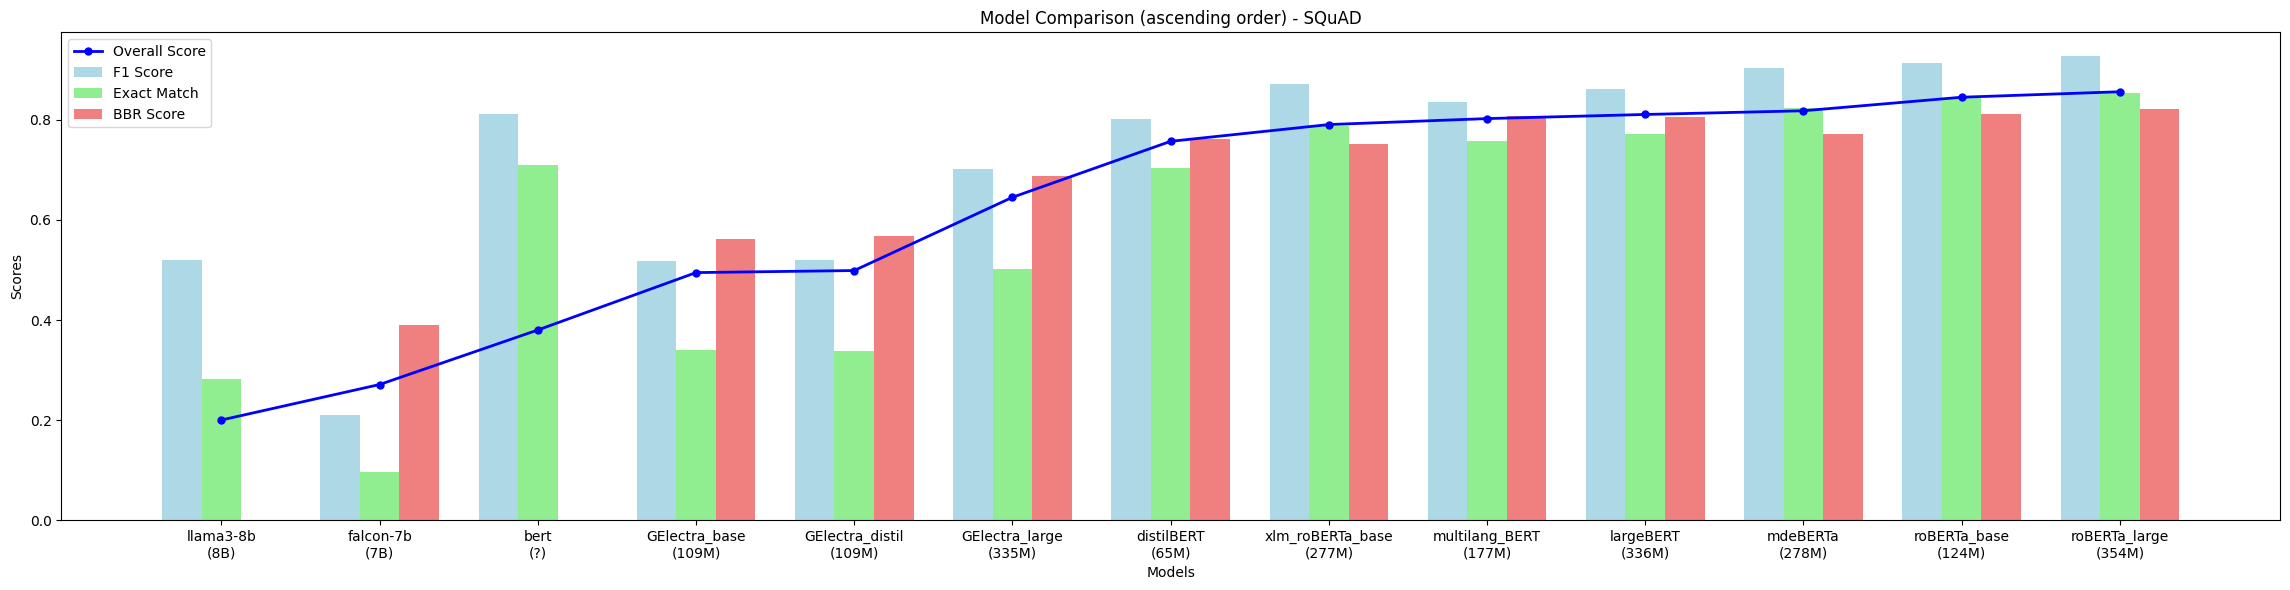

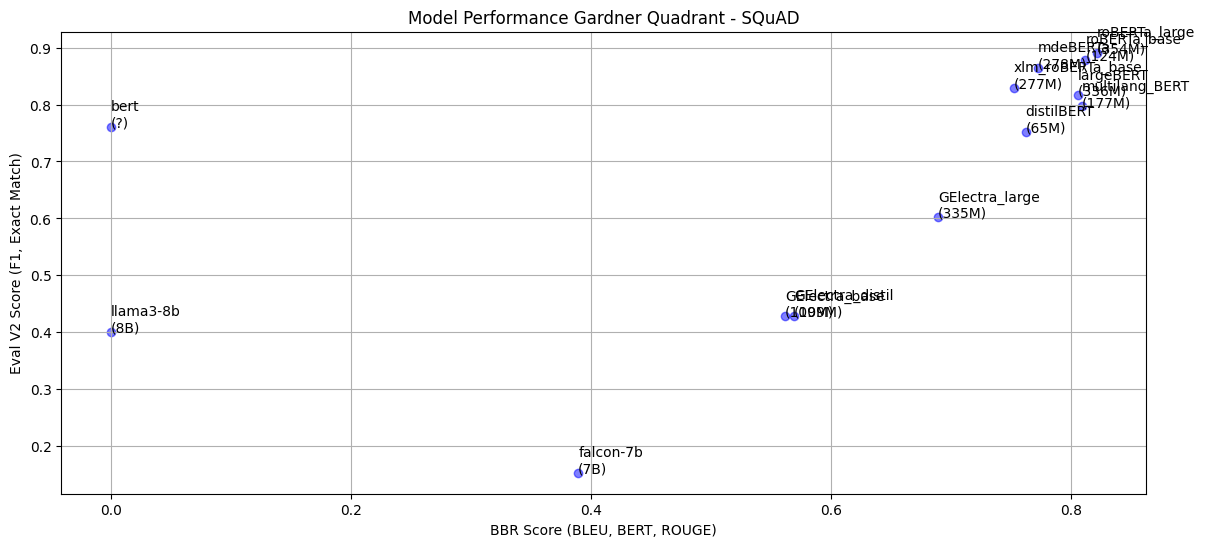

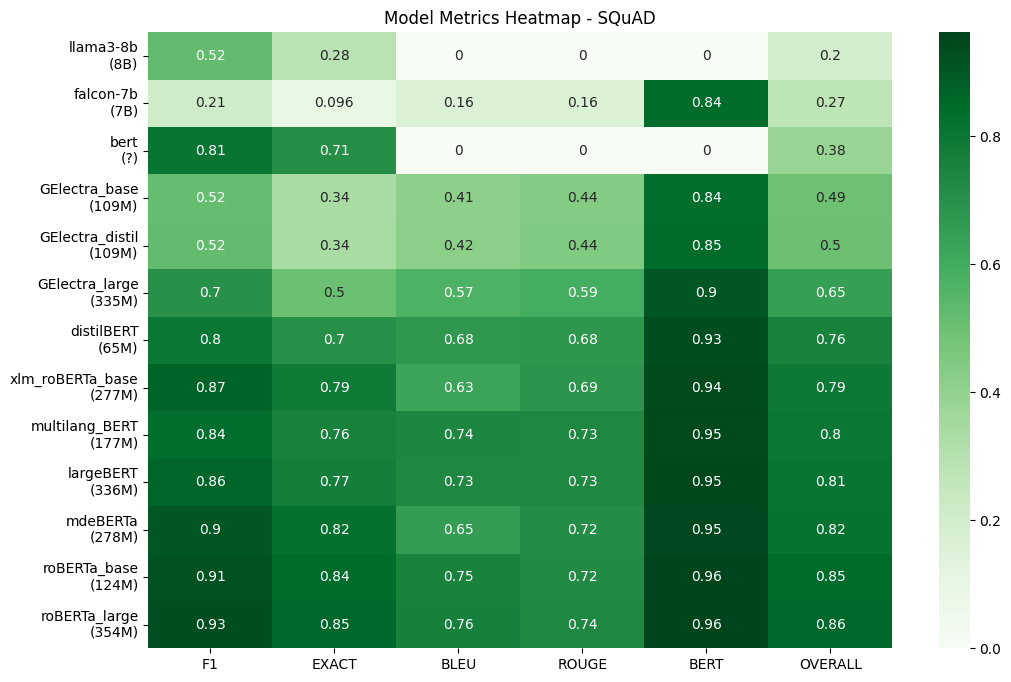

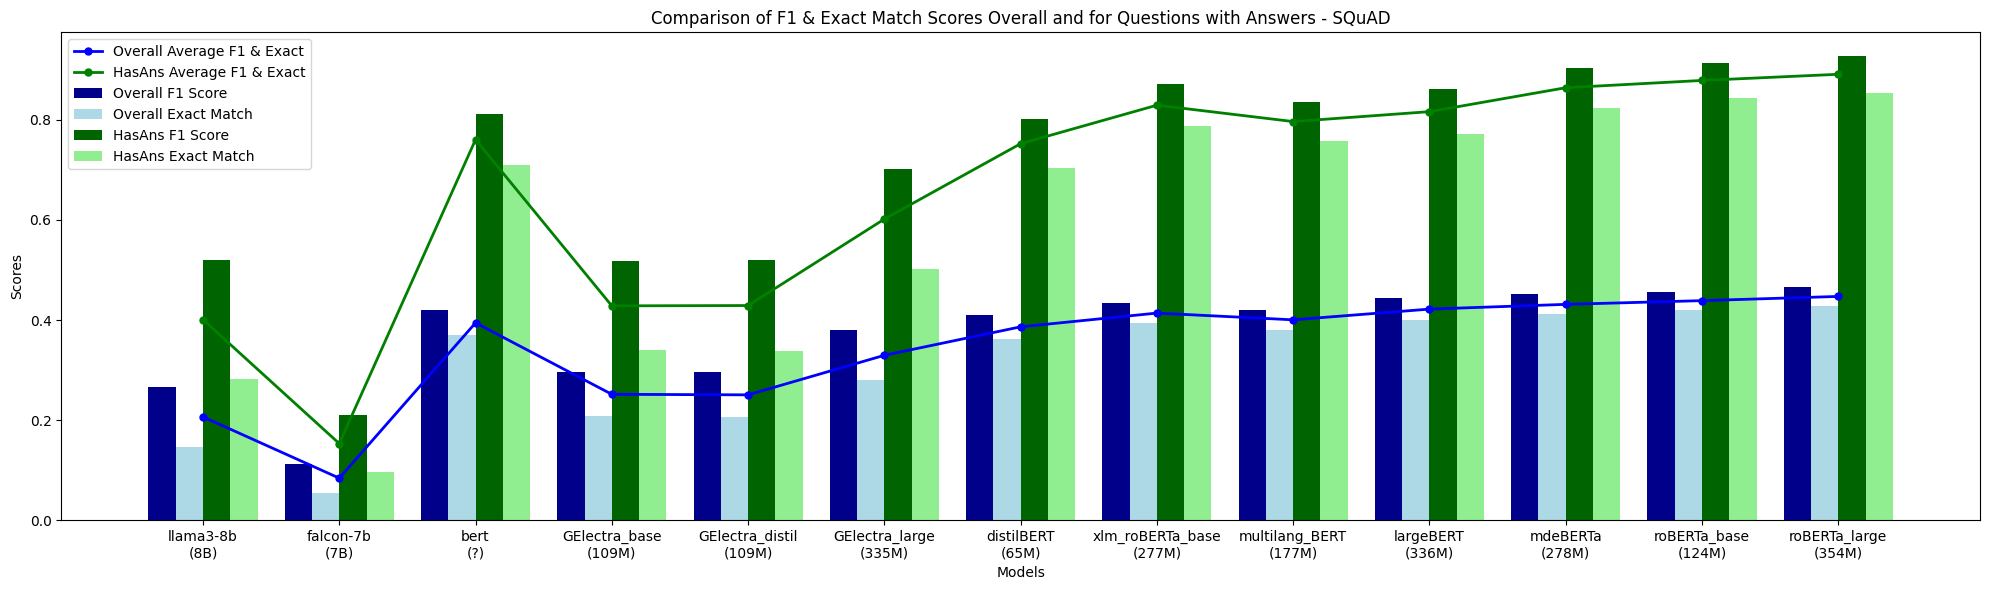

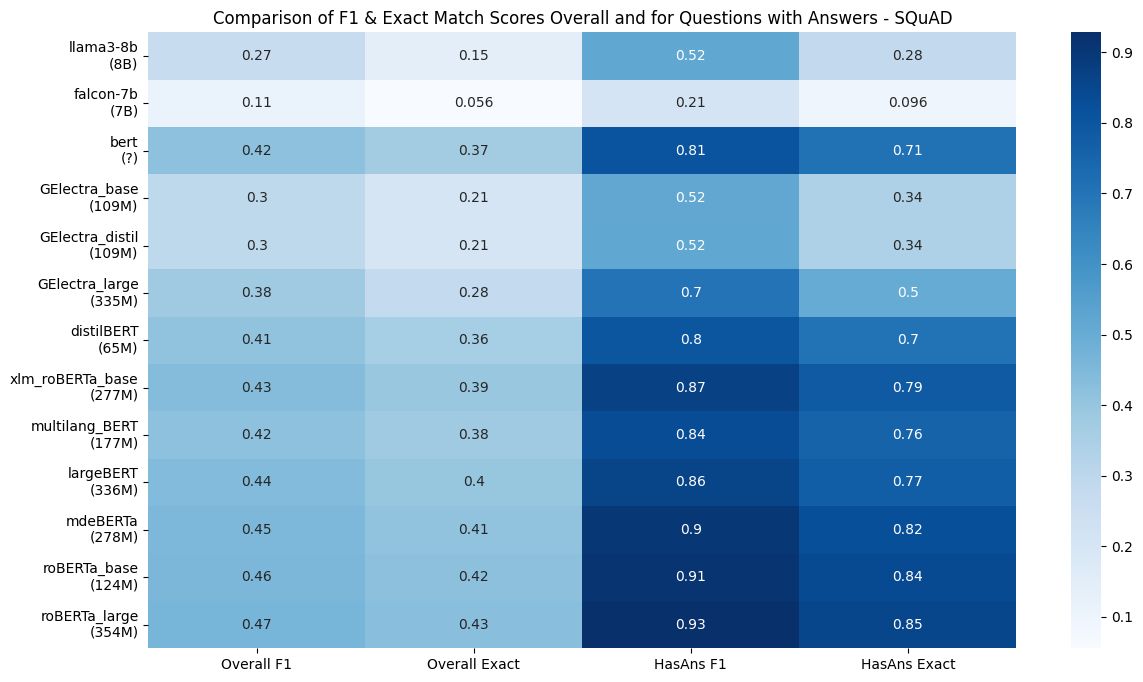

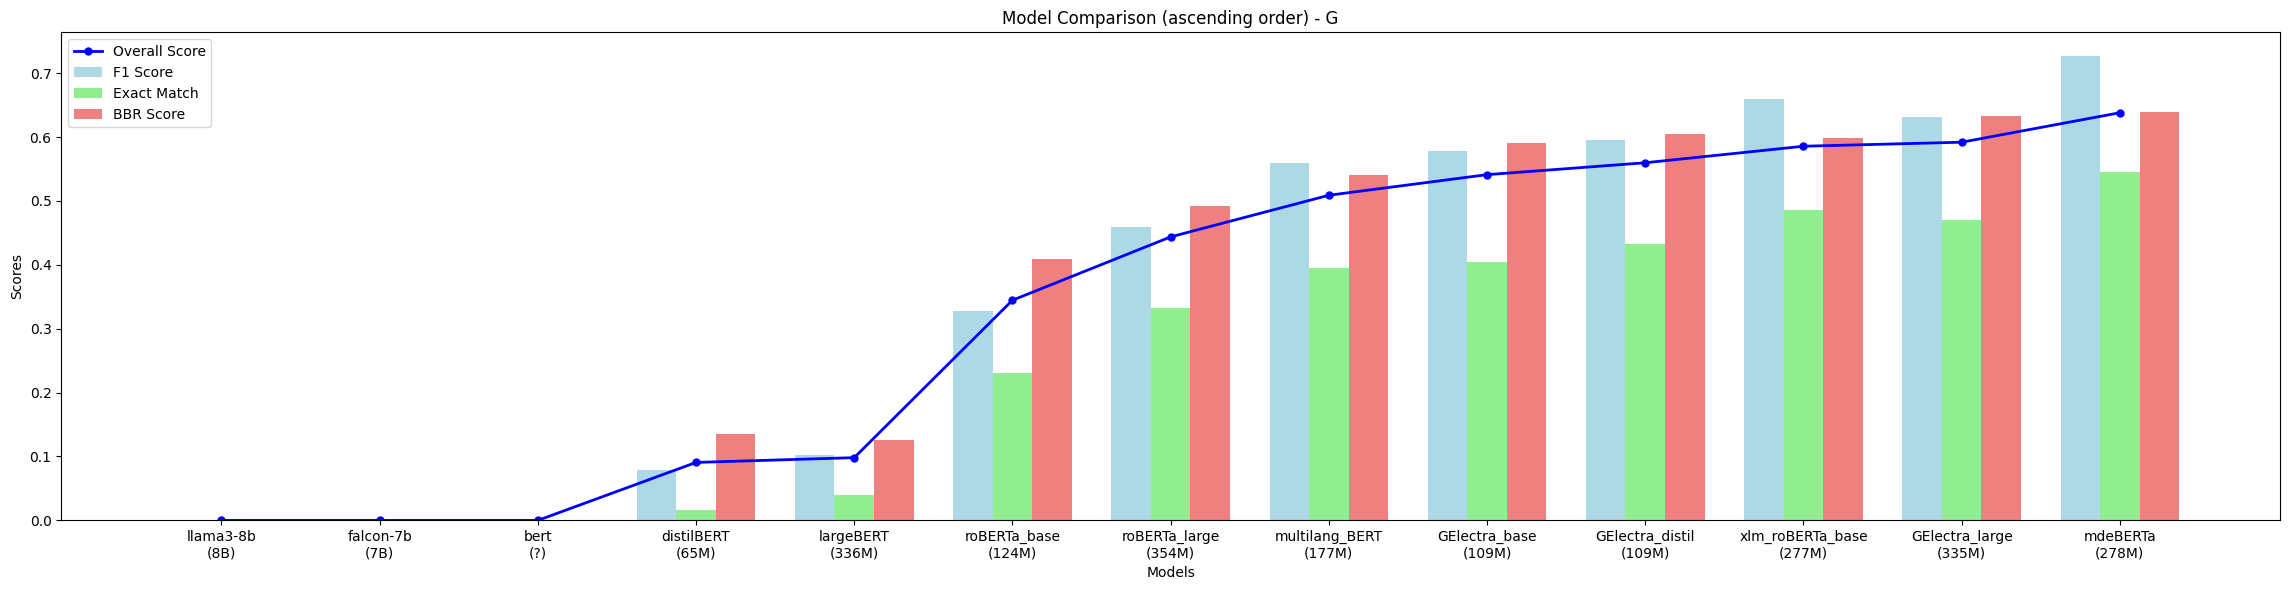

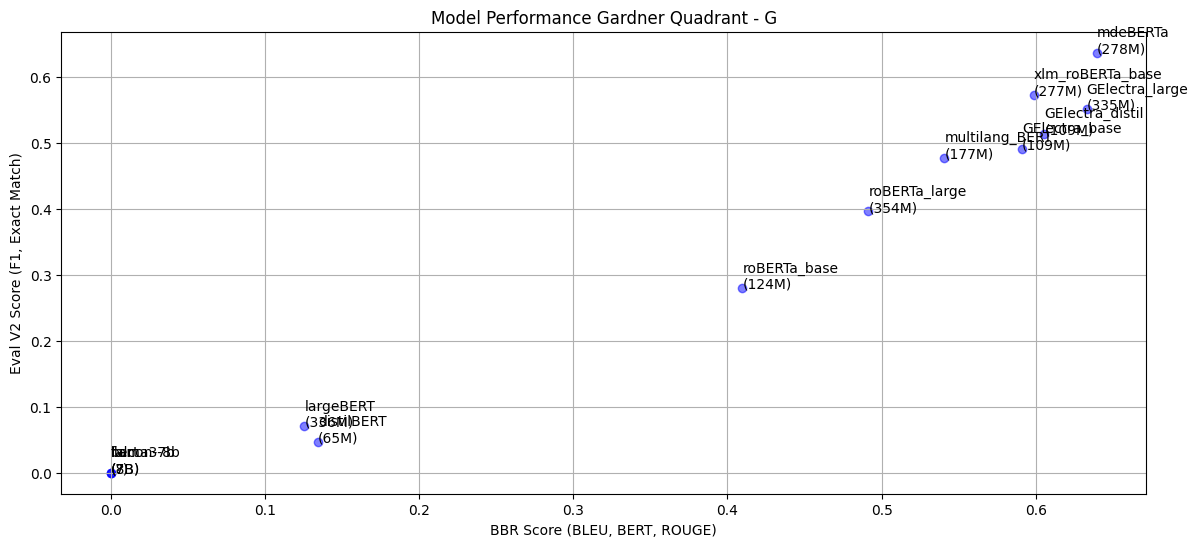

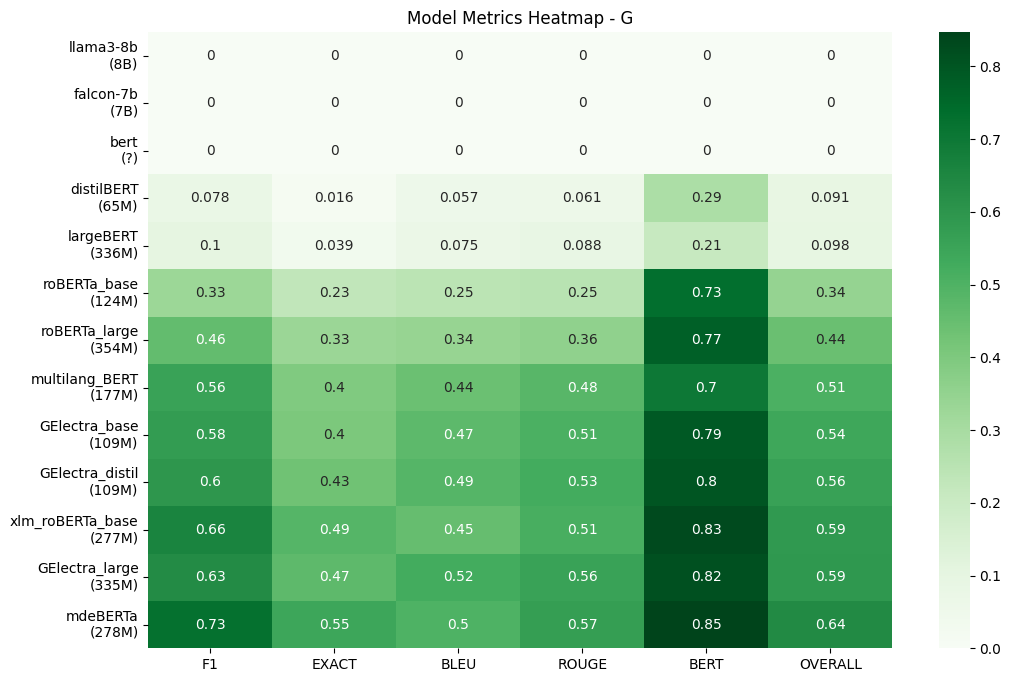

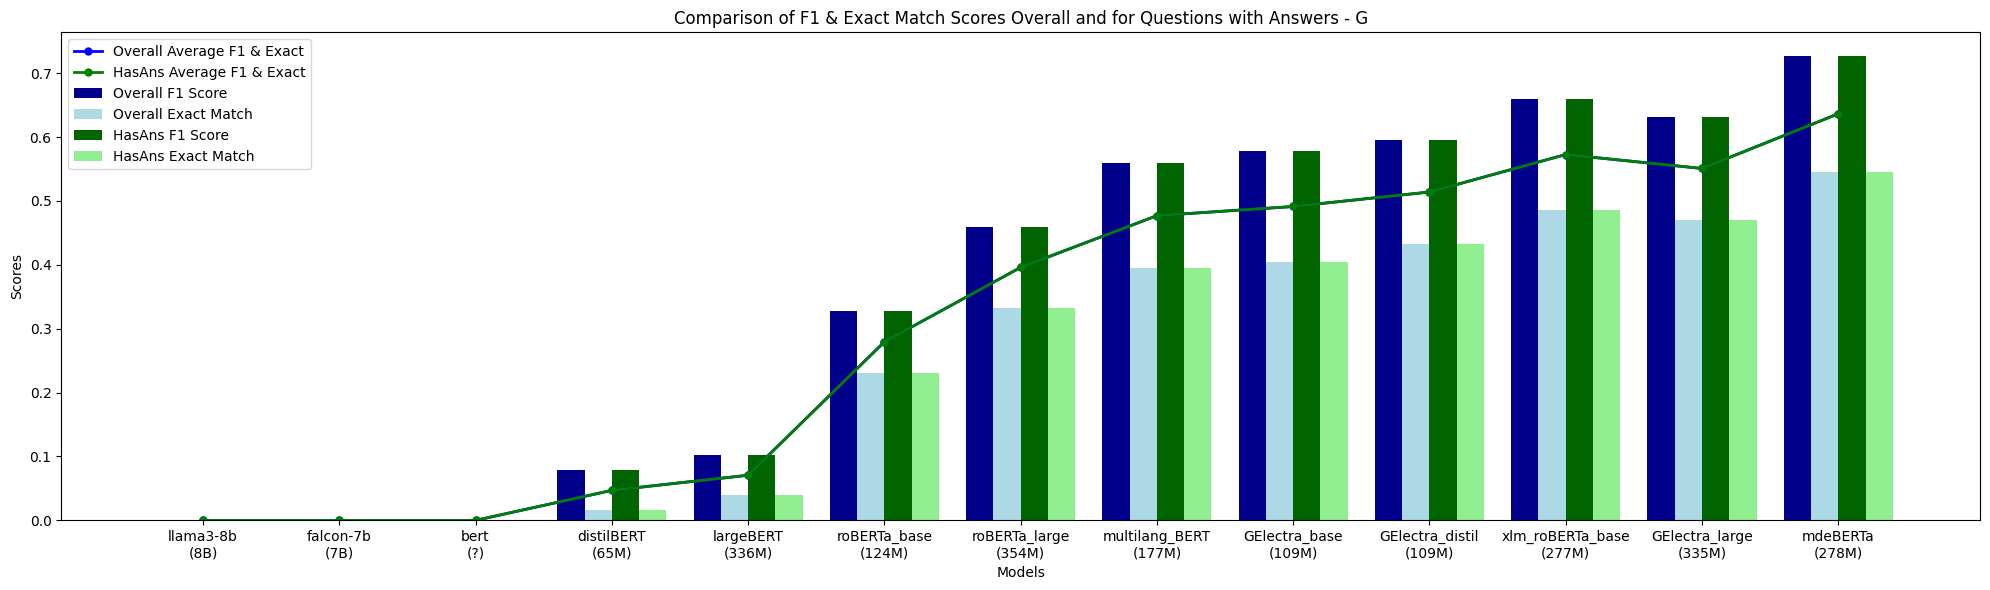

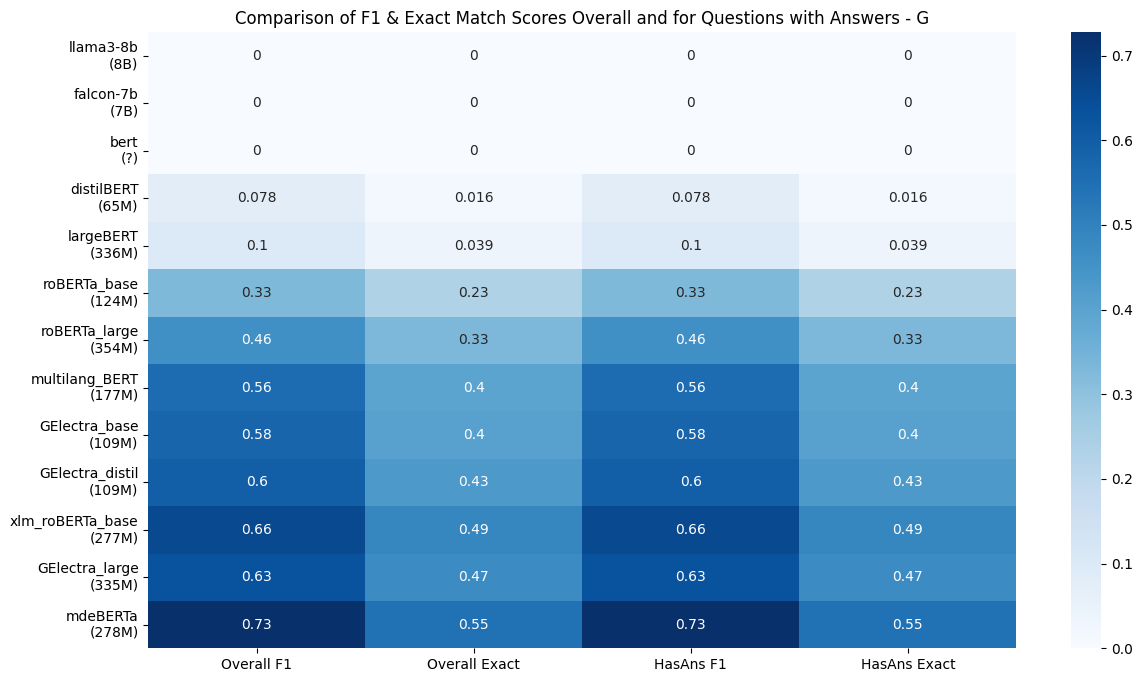

/var/folders/dc/gm62hfbx64d0f98rqwpt3s_h0000gn/T/ipykernel_29725/1359454244.py:150: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = timing_data.applymap(lambda x: f"{x:,}s" if isinstance(x, int) else f"{int(x):,}s")


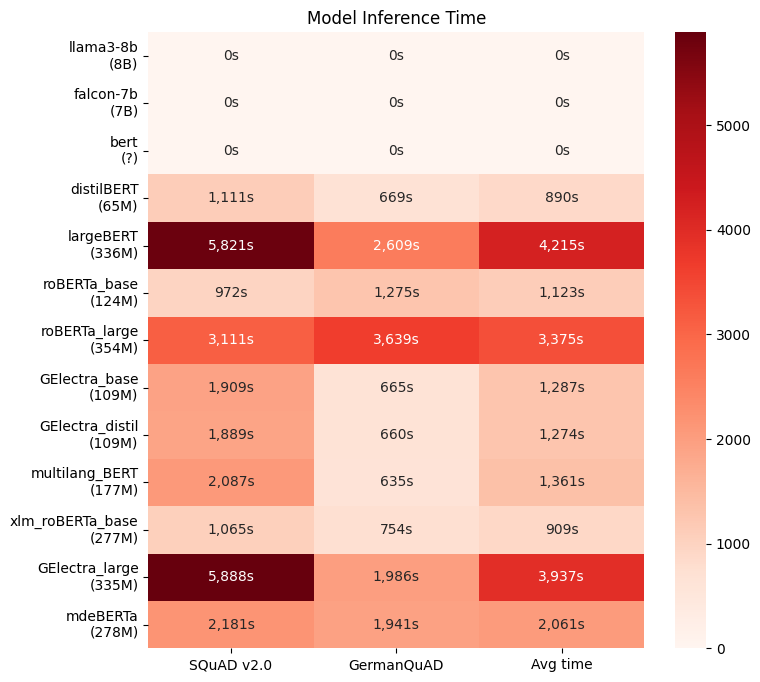

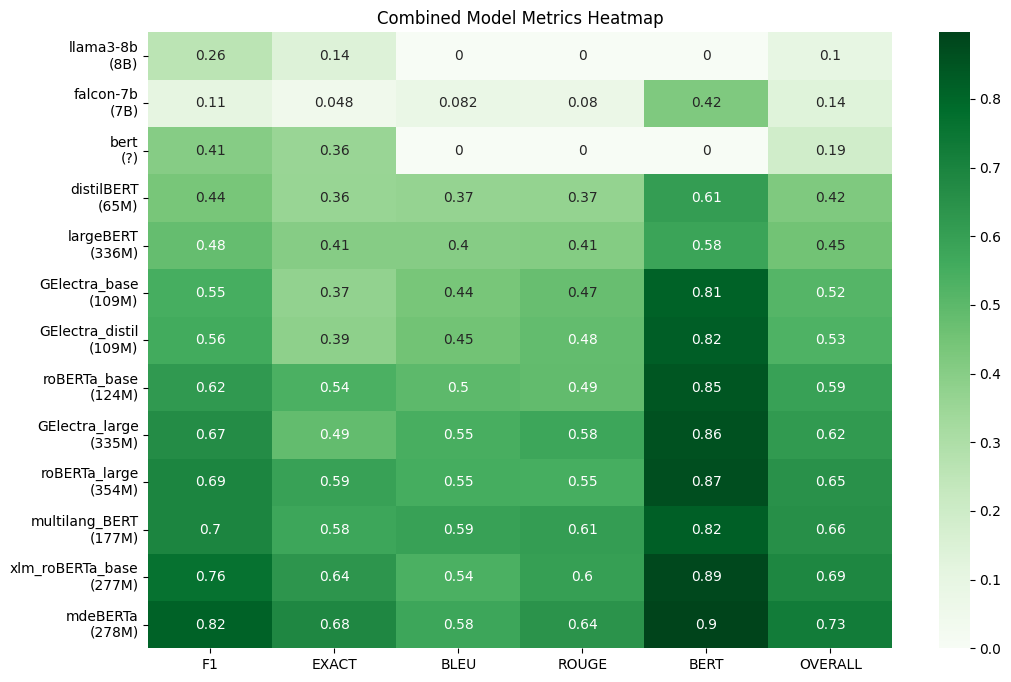

All visualizations have been generated and saved successfully.


In [103]:
# Define the directory paths
base_dir = './eval_results'
figure_root = './figures'
timing_results_path = './timing_results.json'

# Select the subdirectory
subdir = ['base', 'tuned', 'Gtuned'] # options: base, Gbase, tuned, Gtuned

# Load data
data, model_name_map = load_json_files(base_dir, subdir, datasets)

# Load timing results
timing_results = load_timing_results(timing_results_path)

# Create and display DataFrame
df = pd.DataFrame(data)
timing_df = pd.DataFrame.from_dict(timing_results, orient='index').reset_index()
timing_df = timing_df.rename(columns={'index': 'model'})
df = pd.merge(df, timing_df, on='model', how='left')

# Execute visualizations for both datasets
for dataset_name in datasets:
    plot_bar_chart_with_line_graph(df, dataset_name, figure_root)
    plot_gardner_quadrant(df, dataset_name, figure_root)
    plot_heat_map(df, dataset_name, figure_root)
    plot_bar_chart_comparison(df, dataset_name, figure_root)
    plot_comparison_heat_map(df, dataset_name, figure_root)

plot_timing_heat_map(df, figure_root)

print("All visualizations have been generated and saved successfully.")